### Imports & checks

In [10]:
# Import libraries and read train test files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
import re
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from urllib.parse import unquote,unquote_plus

from IPython.core.display import display, HTML



train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

display(train_df.head(),test_df.head())


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
# Check missing data

train_missing_df = pd.DataFrame(data=np.stack([train_df.count().values,train_df.isnull().sum().values],axis=1).tolist(),
                                columns=['not_null','null'],
                                index=train_df.count().index)
train_missing_df['total'] = train_missing_df['not_null']+train_missing_df['null']
train_missing_df['null_contribution'] = np.round((train_missing_df['null']/train_missing_df['total'])*100,2)

test_missing_df = pd.DataFrame(data=np.stack([test_df.count().values,test_df.isnull().sum().values],axis=1).tolist(),
                                columns=['not_null','null'],
                                index=test_df.count().index)
test_missing_df['total'] = test_missing_df['not_null']+test_missing_df['null']
test_missing_df['null_contribution'] = np.round((test_missing_df['null']/test_missing_df['total'])*100,2)


display(train_missing_df,test_missing_df)


,not_null,null,total,null_contribution
id,7613,0,7613,0.00
keyword,7552,61,7613,0.80
location,5080,2533,7613,33.27
text,7613,0,7613,0.00
target,7613,0,7613,0.00


,not_null,null,total,null_contribution
id,3263,0,3263,0.00
keyword,3237,26,3263,0.80
location,2158,1105,3263,33.86
text,3263,0,3263,0.00


In train and test datasets, features *location* and *keyword* have ~33% and ~0.8% nulls respectively. Let's drop location for now

In [12]:
train_df.drop(labels=['location'],axis=1,inplace=True)
test_df.drop(labels=['location'],axis=1,inplace=True)

In [13]:
# Check split of disaster and non-disaster tweets
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Decent ~43/57 split. Can work without any resampling

In [14]:
# Check some disaster tweets
train_df[train_df['target']==1].head(50)

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,I'm afraid that the tornado is coming to our a...,1


In [15]:
# Check some non-disaster tweets
train_df[train_df['target']==0].head(50)

,id,keyword,text,target
15,23,NaN,What's up man?,0
16,24,NaN,I love fruits,0
17,25,NaN,Summer is lovely,0
18,26,NaN,My car is so fast,0
19,28,NaN,What a goooooooaaaaaal!!!!!!,0
20,31,NaN,this is ridiculous....,0
21,32,NaN,London is cool ;),0
22,33,NaN,Love skiing,0
23,34,NaN,What a wonderful day!,0
24,36,NaN,LOOOOOOL,0


#### Preliminary observations
-Not sure if we can use keyword field as a feature. Word cloud might help<br>
-Are disaster tweets longer?<br>
-Hashtags should be captured separately-- might be a useful feature<br>
-Text requires cleaning; links, tags, punctuations can be removed<br>


#### Checking keywords

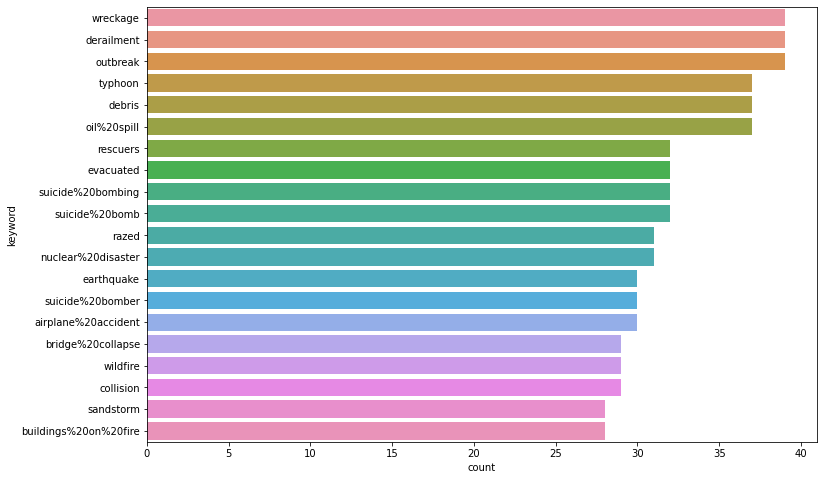

In [16]:
# Top 20 keywords in disaster tweets

plt.figure(figsize=(12,8))
sns.countplot(y= train_df[train_df['target']==1].keyword, 
              order= train_df[train_df['target']==1].keyword.value_counts().iloc[:20].index)



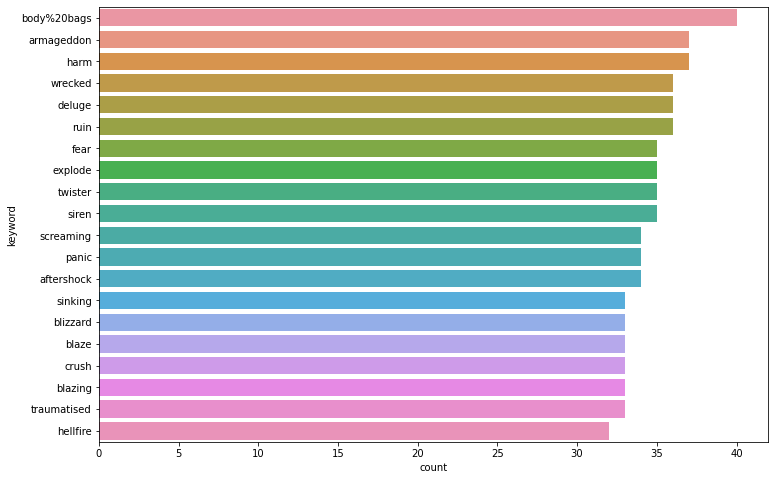

In [17]:
# Top 20 keywords in non-disaster tweets

plt.figure(figsize=(12,8))
sns.countplot(y= train_df[train_df['target']==0].keyword, 
              order= train_df[train_df['target']==0].keyword.value_counts().iloc[:20].index)



### Text Cleaning
Lowercase<br>
Remove all special characters-- commas, quotes, fullstops, numbers etc.<br>
Remove stop words<br>
Remove links and handle tags (http:, www., @, etc.)<br>
Remove emojis<br>
Stemming/Lemmatization

In [9]:
import time

def clean_text_data(text):
    if(pd.isna(text)):
        return None
    text = unquote(unquote_plus(text.lower().lstrip().rstrip())) #lower text, remove trailing, starting spaces, encodings like %20, +
    text = re.sub(r'http.*?\s+|www\..*?\s+|http.*?$|www\..*?$|@.*?\b','',text) #remove links, sites and tags
    text = re.sub(r'[^A-Za-z\s\-]+|[^A-Za-z\s\-]','',text) #remove special characters and numbers
    text = re.sub(r'\-',' ',text) #replace hyphen with space
    text = re.sub(r'\s+',' ',text) #remove multi space with single space
    text = ' '.join([stemmer.lemmatize(word) for word in text.split() if word not in stopwords.words('english')]) #remove stop words and stem
    return text

vec_clean_text_data = np.vectorize(clean_text_data) #vectorize for faster processing


train_df['text'] = vec_clean_text_data(train_df['text'].values)
test_df['text'] = vec_clean_text_data(test_df['text'].values)
train_df['keyword'] = vec_clean_text_data(train_df['keyword'].values)
test_df['keyword'] = vec_clean_text_data(test_df['keyword'].values)

train_df.head()


,id,keyword,text,target
0,1,None,deed reason earthquake may allah forgive u,1
1,4,None,forest fire near la ronge sask canada,1
2,5,None,resident asked shelter place notified officer ...,1
3,6,None,people receive wildfire evacuation order calif...,1
4,7,None,got sent photo ruby alaska smoke wildfire pour...,1


### Setup model imports and TF-IDF vectorizer

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report


In [19]:
# Split train_df into training_data and validation_data
training_data,validation_data = train_test_split(train_df, test_size=0.33, random_state=42)

# ignoring terms that appear in less than 5 documents and more than 90% of the documents;
tfidf = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1,2))
X_td = tfidf.fit_transform(training_data["text"])

### Baseline Naive Bayes model
Naive Bayes is one of the simplest models for text classification. While similar to linear models, they are generally fast while training and serve as a decent candidate for a baseline model

In [20]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_td.toarray(),training_data['target'].values)
y_td = nb_model.predict(X_td.toarray())

print("Training data results\n")
print(classification_report(y_true=training_data['target'].values, y_pred=y_td))
print("\n")

X_vd = tfidf.transform(validation_data["text"])
y_vd = nb_model.predict(X_vd.toarray())
print("Validation data results\n")
print(classification_report(y_true=validation_data['target'].values, y_pred=y_vd))


Training data results

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2896
           1       0.91      0.68      0.78      2204

    accuracy                           0.83      5100
   macro avg       0.86      0.82      0.82      5100
weighted avg       0.85      0.83      0.83      5100



Validation data results

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1446
           1       0.86      0.63      0.73      1067

    accuracy                           0.80      2513
   macro avg       0.82      0.78      0.78      2513
weighted avg       0.81      0.80      0.79      2513



Good baseline model training data accuracy ~0.83 and test data ~0.80

### Can we reduce the number of TF-IDF features?

In [22]:
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=20)
selector.fit(X_td, y_td)

X_td_new = selector.transform(X_td)
X_vd_new = selector.transform(X_vd)



In [23]:
nb_model = MultinomialNB()
nb_model.fit(X_td_new.toarray(),training_data['target'].values)
y_td_new = nb_model.predict(X_td_new.toarray())

print("Training data results\n")
print(classification_report(y_true=training_data['target'].values, y_pred=y_td_new))
print("\n")

y_vd_new = nb_model.predict(X_vd_new.toarray())
print("Validation data results\n")
print(classification_report(y_true=validation_data['target'].values, y_pred=y_vd_new))


Training data results

              precision    recall  f1-score   support

           0       0.73      0.98      0.84      2896
           1       0.94      0.53      0.68      2204

    accuracy                           0.78      5100
   macro avg       0.84      0.75      0.76      5100
weighted avg       0.82      0.78      0.77      5100



Validation data results

              precision    recall  f1-score   support

           0       0.71      0.96      0.82      1446
           1       0.90      0.47      0.61      1067

    accuracy                           0.75      2513
   macro avg       0.81      0.71      0.72      2513
weighted avg       0.79      0.75      0.73      2513



Reducing features is not helping with the accuracy, although with an 80% reduction in the features naive bayes accuracy has only dropped by 5% points.

### Logistic Regression model

In [24]:
logit = LogisticRegression()
logit.fit(X_td, training_data['target'].values)
y_td = logit.predict(X_td)
print("Training data results\n")
print(classification_report(y_true=training_data['target'].values, y_pred=y_td))
print("\n")

y_vd = logit.predict(X_vd)
print("Validation data results\n")
print(classification_report(y_true=validation_data['target'].values, y_pred=y_vd))


Training data results

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2896
           1       0.90      0.76      0.83      2204

    accuracy                           0.86      5100
   macro avg       0.87      0.85      0.86      5100
weighted avg       0.87      0.86      0.86      5100



Validation data results

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1446
           1       0.82      0.68      0.74      1067

    accuracy                           0.80      2513
   macro avg       0.80      0.78      0.79      2513
weighted avg       0.80      0.80      0.80      2513



In [25]:
# Create submission file
X_test = tfidf.transform(test_df["text"])
test_ylabels = logit.predict(X_test)

sample_sub=pd.read_csv('data/sample_submission.csv')
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':test_ylabels})
sub.to_csv('submission.csv',index=False)
